# API Client Test Notebook

This notebook directly tests the API endpoints by making HTTP requests to the server running on port 8000.
We'll test the following flows in sequence:

1. Authentication and getting a session token
2. Getting customer information
3. Managing payment methods
4. Products and subscription tiers
5. Buying tokens and subscribing to plans
6. Two-factor authentication

In [3]:
import os
import json
import httpx
import pandas as pd
import pyotp
import asyncio
import base64
from IPython.display import Image, HTML, display

In [4]:
# Configure API base URL
API_BASE_URL = "http://localhost:8000"

# Test user credentials
TEST_USER = {
    "email": "test@example.com",
    "password": "Password123!", 
    "name": "Test User"
}

# Session storage
session = {
    "token": None,
    "user": None,
    "mfa_secret": None
}

## Helper Functions

In [63]:
async def make_api_request(method, endpoint, data=None, token=None):
    """Make a request to the API"""
    url = f"{API_BASE_URL}{endpoint}"
    headers = {}
    cookies = {}
    
    # Add session_id as cookie for authentication
    if token:
        cookies["session_id"] = token
        # Also include Authorization header as fallback
        headers["Authorization"] = f"Bearer {token}"
    
    print(f"Making {method.upper()} request to {url}")
    
    async with httpx.AsyncClient(timeout=60.) as client:
        if method.lower() == "get":
            response = await client.get(url, headers=headers, cookies=cookies)
        elif method.lower() == "post":
            response = await client.post(url, json=data, headers=headers, cookies=cookies)
        elif method.lower() == "put":
            response = await client.put(url, json=data, headers=headers, cookies=cookies)
        elif method.lower() == "delete":
            response = await client.delete(url, headers=headers, cookies=cookies)
        else:
            raise ValueError(f"Unsupported method: {method}")
        
        print(f"Response status: {response.status_code}")
        
        if response.status_code >= 400:
            error_detail = response.text
            try:
                error_json = response.json()
                if "detail" in error_json:
                    error_detail = error_json["detail"]
            except:
                pass
            
            print(f"API error: {error_detail}")
            return {"error": error_detail, "status_code": response.status_code}
        
        try:
            result = response.json()
            # Check for session_id cookie
            if "session_id" in response.cookies:
                result["session_id"] = response.cookies["session_id"]
            return result
        except Exception as e:
            print(f"Error parsing API response as JSON: {str(e)}")
            return {"error": "Invalid JSON response", "data": response.text}

In [1]:
from app.models.user import Users
import percolate as p8
users = p8.repository(Users).select(session_id="6aee68f62442d0a6f0bd3792d52a0849155ccdbebd515c99758063cd20892d28")
users

[{'email': 'amartey@gmail.com',
  'name': 'Saoirse Amarteifio',
  'avatar': 'https://lh3.googleusercontent.com/a/ACg8ocLiYP3pm-tzhsVLRn9XbgPPVHxH0Zy0cGgMt2jaEAckpOIoLTDg=s96-c',
  'auth_method': 'google',
  'session_expiry': datetime.datetime(2025, 4, 2, 12, 22, 8, 280380),
  'mfa_enabled': False,
  'stripe_customer_id': None,
  'id': '10e0a97d-a064-553a-9043-3c1f0a6e6725',
  'session_id': '6aee68f62442d0a6f0bd3792d52a0849155ccdbebd515c99758063cd20892d28',
  'hashed_password': None,
  'auth_provider': None,
  'provider_user_id': '102165476114804096230',
  'subscription_tier': 'Free',
  'credits': 0,
  'mfa_secret': None}]

In [2]:
Users(**users[0]).is_expired()

False

In [5]:
response = await make_api_request("get", "/auth/google/login")

Making GET request to http://localhost:8000/auth/google/login
Response status: 307
Error parsing API response as JSON: Expecting value: line 1 column 1 (char 0)


In [27]:
response = await make_api_request("get", "/auth/me", 
                                  token= '6aee68f62442d0a6f0bd3792d52a0849155ccdbebd515c99758063cd20892d28'
                                 )
response

Making GET request to http://localhost:8000/auth/me
Response status: 200


{'email': 'amartey@gmail.com',
 'name': 'Saoirse Amarteifio',
 'avatar': 'https://lh3.googleusercontent.com/a/ACg8ocLiYP3pm-tzhsVLRn9XbgPPVHxH0Zy0cGgMt2jaEAckpOIoLTDg=s96-c',
 'auth_method': 'google',
 'session_expiry': '2025-04-02T12:22:08.280380',
 'mfa_enabled': False,
 'stripe_customer_id': None}

In [35]:
response = await make_api_request("put", "/auth/ensure-stripe-customer", 
                                  token= '6aee68f62442d0a6f0bd3792d52a0849155ccdbebd515c99758063cd20892d28'
                                 )
response

Making PUT request to http://localhost:8000/auth/ensure-stripe-customer
Response status: 200


{'email': 'amartey@gmail.com',
 'name': 'Saoirse Amarteifio',
 'avatar': 'https://lh3.googleusercontent.com/a/ACg8ocLiYP3pm-tzhsVLRn9XbgPPVHxH0Zy0cGgMt2jaEAckpOIoLTDg=s96-c',
 'auth_method': 'google',
 'session_expiry': '2025-04-02T12:22:08.280380',
 'mfa_enabled': False,
 'stripe_customer_id': 'cus_S2vR9ky8LO8p8M'}

In [36]:
response = await make_api_request("get", "/payments/methods", 
                                  token= '6aee68f62442d0a6f0bd3792d52a0849155ccdbebd515c99758063cd20892d28'
                                 )
response

Making GET request to http://localhost:8000/payments/methods
Response status: 200


[{'id': 'pm_1R8pb4GD1DBgwakwkqCxqAUQ',
  'type': 'card',
  'brand': 'visa',
  'last4': '4242',
  'exp_month': 10,
  'exp_year': 2027,
  'is_default': True}]

In [47]:
def display_qr_code(qr_code_url):
    """Display QR code image from data URL"""
    try:
        # Check if it's a URL or a data URL
        if qr_code_url.startswith('data:image/'):
            # Extract base64 data
            img_data = qr_code_url.split(',')[1]
            img_bytes = base64.b64decode(img_data)
            
            # Display image
            display(Image(data=img_bytes))
        else:
            # Display URL image
            display(Image(url=qr_code_url))
    except Exception as e:
        print(f"Error displaying QR code: {str(e)}")
        print(f"QR Code URL: {qr_code_url}")

In [48]:
def generate_totp_code(secret):
    """Generate a TOTP code from a secret key"""
    totp = pyotp.TOTP(secret)
    return totp.now()

## 1. Authentication

First, we register a user or login with existing credentials to get a session token.

In [49]:
async def register_user(email, password, name=None):
    """Register a new user"""
    data = {
        "email": email,
        "password": password,
        "name": name
    }
    
    response = await make_api_request("post", "/auth/register", data)
    
    if "error" in response:
        print(f"Registration failed: {response['error']}")
        return None
    
    # Store session information
    if "session_id" in response:
        session["token"] = response["session_id"]
    session["user"] = response
    
    print(f"Registered user: {response.get('email')}")
    return response

# Run the registration
user = await register_user(TEST_USER["email"], TEST_USER["password"], TEST_USER["name"])

if user:
    print(f"User {user['email']} registered or already exists")
    display(pd.Series(user).to_frame("User Profile"))

Making POST request to http://localhost:8000/auth/register
Response status: 200
Registered user: test@example.com
User test@example.com registered or already exists


,User Profile
email,test@example.com
name,Test User
avatar,None
user_id,84e1b0a4-c0c2-419d-8f5d-5adb0f2aa6f2
session_id,d15584195acd4287a5be409e08a07c56b9709062b518a7...
auth_method,password
session_expiry,2025-04-01T23:59:52.248500
mfa_enabled,False


In [50]:
async def login_user(email, password):
    """Login with email and password"""
    data = {
        "email": email,
        "password": password
    }
    
    response = await make_api_request("post", "/auth/login", data)
    
    if "error" in response:
        print(f"Login failed: {response['error']}")
        return None
    
    # Store session information
    if "session_id" in response:
        session["token"] = response["session_id"]
    session["user"] = response
    
    print(f"Logged in as: {response.get('email')}")
    return response

# Run the login
user = await login_user(TEST_USER["email"], TEST_USER["password"])

if user:
    print(f"User {user['email']} logged in successfully")
    display(pd.Series(user).to_frame("User Profile"))

Making POST request to http://localhost:8000/auth/login
Response status: 200
Logged in as: test@example.com
User test@example.com logged in successfully


,User Profile
email,test@example.com
name,Test User
avatar,None
user_id,84e1b0a4-c0c2-419d-8f5d-5adb0f2aa6f2
session_id,8fe758b6dfc5833bc220c7aad064166c1282c97514b40c...
auth_method,password
session_expiry,2025-04-01T23:59:56.000162
mfa_enabled,False


In [32]:
async def get_user_profile():
    """Get current user profile"""
    if not session["token"]:
        print("Not logged in")
        return None
    
    response = await make_api_request("get", "/auth/me", token=session["token"])
    
    if "error" in response:
        print(f"Failed to get user profile: {response['error']}")
        return None
    
    # Update session user data
    session["user"] = response
    
    print(f"Profile for: {response.get('email')}")
    return response

# Get user profile
user_profile = await get_user_profile()

if user_profile:
    display(pd.Series(user_profile).to_frame("User Profile"))

Making GET request to http://localhost:8000/auth/me
Response status: 200
Profile for: test@example.com


,User Profile
email,test@example.com
name,Test User
avatar,None
user_id,d7de1c74-0d8f-43f9-85de-7cb072b1917b
session_id,644b1c8b0840de95a163511b16d831142223dd3672c1c7...
auth_method,password
session_expiry,2025-04-01T23:44:15.069248
mfa_enabled,False


## 2. Stripe Customer Information

Get or create a Stripe customer for the logged-in user.

In [33]:
async def get_stripe_customer_info():
    """Get Stripe customer information for the current user"""
    if not session["token"]:
        print("Not logged in")
        return None
    
    # First check if the user profile already has a customer ID
    user = session.get("user", {})
    
    if user.get("stripe_customer_id"):
        print(f"User already has Stripe customer ID: {user['stripe_customer_id']}")
        return {"customer_id": user["stripe_customer_id"]}
    
    # Otherwise, try to fetch by email
    if not user.get("email"):
        print("No email available to lookup customer")
        return None
    
    response = await make_api_request(
        "get", 
        f"/payments/customer-by-email?email={user['email']}", 
        token=session["token"]
    )
    
    if "error" in response:
        print(f"Failed to get customer info: {response['error']}")
        return None
    
    if response.get("found") and response.get("customer_id"):
        print(f"Retrieved Stripe customer ID: {response['customer_id']}")
        # Update the user data
        user["stripe_customer_id"] = response["customer_id"]
        session["user"] = user
        return response
    else:
        print("No Stripe customer found for this user")
        return None

# Get Stripe customer info
customer_info = await get_stripe_customer_info()

if customer_info:
    display(pd.Series(customer_info).to_frame("Stripe Customer Info"))
else:
    print("No customer found, will create one in the next step")

Making GET request to http://localhost:8000/payments/customer-by-email?email=test@example.com
Response status: 200
Retrieved Stripe customer ID: cus_S2xrXIfbWYk8dK


,Stripe Customer Info
found,True
customer_id,cus_S2xrXIfbWYk8dK
email,test@example.com
name,Test User
created,1743464378


In [34]:
async def create_stripe_customer():
    """Create a Stripe customer for the current user by getting a setup intent"""
    if not session["token"]:
        print("Not logged in")
        return None
    
    # Check if the user already has a customer ID
    user = session.get("user", {})
    if user.get("stripe_customer_id"):
        print(f"User already has Stripe customer ID: {user['stripe_customer_id']}")
        return {"customer_id": user["stripe_customer_id"]}
    
    # Create a setup intent to generate a customer
    response = await make_api_request("post", "/payments/setup-intent", {}, session["token"])
    
    if "error" in response:
        print(f"Failed to create Stripe customer: {response['error']}")
        return None
    
    if response.get("customer_id"):
        print(f"Created Stripe customer ID: {response['customer_id']}")
        
        # Update user data
        user["stripe_customer_id"] = response["customer_id"]
        session["user"] = user
        
        return response
    else:
        print("No customer ID returned")
        return None

# Create a Stripe customer and get setup intent
setup_intent = await create_stripe_customer()

if setup_intent:
    print(f"Setup intent created successfully")
    display(pd.Series(setup_intent).to_frame("Stripe Setup Intent"))

User already has Stripe customer ID: cus_S2xrXIfbWYk8dK
Setup intent created successfully


,Stripe Setup Intent
customer_id,cus_S2xrXIfbWYk8dK


## 3. Payment Methods

In [35]:
async def get_payment_methods():
    """Get payment methods for the current user"""
    if not session["token"]:
        print("Not logged in")
        return None
    
    response = await make_api_request("get", "/payments/methods", token=session["token"])
    
    if "error" in response:
        print(f"Failed to get payment methods: {response['error']}")
        return None
    
    if isinstance(response, list):
        print(f"Found {len(response)} payment methods")
        return response
    else:
        print("Unexpected response format")
        return None

# Get payment methods
payment_methods = await get_payment_methods()

if payment_methods:
    if len(payment_methods) > 0:
        display(pd.DataFrame(payment_methods))
    else:
        print("No payment methods found. You can add a card through the test client.")
        print("Visit http://localhost:7999, login, and go to the Payments tab to add a card.")

Making GET request to http://localhost:8000/payments/methods
Response status: 200
Found 0 payment methods


In [36]:
#Add logic here to add payment method

To add a payment method, you need to use the test client UI.
1. Login with the same credentials used in this notebook
2. Go to the Payments tab
3. Click 'Add Payment Method'
4. Use a Stripe test card like 4242 4242 4242 4242
5. Return to this notebook and run the next cell to verify the card was added


In [13]:
# Check for payment methods after adding through test client
payment_methods = await get_payment_methods()

if payment_methods and len(payment_methods) > 0:
    print("Payment methods found:")
    display(pd.DataFrame(payment_methods))
else:
    print("No payment methods found yet. Add a card through the test client.")

Making GET request to http://localhost:8000/payments/methods
Response status: 200
Found 0 payment methods
No payment methods found yet. Add a card through the test client.


## 4. Products and Subscription Tiers

In [55]:
async def initialize_products():
    """Initialize products in the system"""
 
    
    response = await make_api_request("post", "/payments/initialize-products",  )
    
    if "error" in response:
        print(f"Product initialization failed: {response['error']}")
        return None
    
    print("Products initialized successfully")
    return response

# Initialize products
products_initialized = await initialize_products()
products_initialized

Making POST request to http://localhost:8000/payments/initialize-products
Response status: 200
Products initialized successfully


[{'id': 'f2773616-09a3-5ca1-ab96-3fd88753c9bf',
  'name': 'Individual Subscription',
  'description': 'Individual tier subscription',
  'active': True,
  'price_id': '887b8625-0546-54a9-b492-9e5024e0c139',
  'price': 9.99,
  'currency': 'usd',
  'metadata': {'stripe_product_id': 'prod_S3Cd01RTYeuRlq',
   'stripe_price_id': 'price_1R96FkGD1DBgwakwW4YCFykW',
   'type': 'subscription',
   'tier': 'Individual',
   'credits': 100},
  'features': [],
  'product_type': 'subscription',
  'recurs': 'monthly',
  'stripe_product_id': 'prod_S3Cd01RTYeuRlq',
  'stripe_price_id': 'price_1R96FkGD1DBgwakwW4YCFykW'},
 {'id': '3929e05f-2920-5be6-9825-3af15154ee95',
  'name': 'Team Subscription',
  'description': 'Team tier subscription',
  'active': True,
  'price_id': 'baa5f711-7285-5b5e-9220-2b7c49892d62',
  'price': 49.99,
  'currency': 'usd',
  'metadata': {'stripe_product_id': 'prod_S3CewjZ0yeJgpZ',
   'stripe_price_id': 'price_1R96FlGD1DBgwakwr5NbGqui',
   'type': 'subscription',
   'tier': 'Team'

In [37]:
async def get_products():
    """Get all products"""
    response = await make_api_request("get", "/payments/products")
    
    if "error" in response:
        print(f"Failed to get products: {response['error']}")
        return None
    
    if isinstance(response, list):
        print(f"Found {len(response)} products")
        return response
    else:
        print("Unexpected response format")
        return None

# Get products
products = await get_products()

if products:
    display(pd.DataFrame(products))

Making GET request to http://localhost:8000/payments/products
Response status: 200
Found 0 products


## 4. Payment Methods

In [66]:
async def subscribe_to_plan(tier, token):
 
    data = {
        "tier": tier,
        "success_url": f"{API_BASE_URL}/payments/success?session_id={{CHECKOUT_SESSION_ID}}", 
        "cancel_url": f"{API_BASE_URL}/payments"
    }
    
    response = await make_api_request("post", "/payments/subscribe", data, token)
    
    if "error" in response:
        print(f"Subscription failed: {response['error']}")
        return None
    
    print(f"Subscription initiated. Checkout URL: {response.get('url')}")
    
    # Display checkout link
    #display(HTML(f'<a href="{response.get("url")}" target="_blank">Complete Subscription</a>'))
    
    return response

# Subscribe to a plan (uncomment to execute)
subscription = await subscribe_to_plan("Individual Subscription",
                                       token='6aee68f62442d0a6f0bd3792d52a0849155ccdbebd515c99758063cd20892d28')

subscription

Making POST request to http://localhost:8000/payments/subscribe
Response status: 200
Subscription initiated. Checkout URL: None


{'id': 'sub_1R96aEGD1DBgwakwiIMYUIEt',
 'status': 'active',
 'current_period_start': '2025-04-01T11:18:34',
 'current_period_end': '2025-05-01T11:18:34',
 'customer_id': 'cus_S2vR9ky8LO8p8M',
 'tier_name': 'Individual Subscription'}

In [77]:
async def buy_tokens(amount, token):
    """Buy tokens
    
    This function initiates a token purchase through the API. It sends:
    1. The token amount to purchase
    2. Success and cancel URLs for the checkout process
    3. The session token for authentication
    
    The API will:
    1. Find the token product with its price
    2. Ensure minimum purchase requirement is met
    3. Create a checkout session with the correct quantity
    4. Return a checkout URL
    
    Once the checkout is completed via Stripe, the API updates the user's credits
    through a webhook or success URL verification.
    """

    data = {
        "amount": amount,
        "success_url": f"{API_BASE_URL}/payments/success?session_id={{CHECKOUT_SESSION_ID}}", 
        "cancel_url": f"{API_BASE_URL}/payments"
    }
    
    response = await make_api_request("post", "/payments/buy-tokens", data, token)
    

    return response

# Buy tokens (uncomment to execute)
token_purchase = await buy_tokens(200, token='6aee68f62442d0a6f0bd3792d52a0849155ccdbebd515c99758063cd20892d28')
token_purchase

Making POST request to http://localhost:8000/payments/buy-tokens
Response status: 200


{'payment_id': 'pi_3R96uyGD1DBgwakw0o77KVwB',
 'amount': 200,
 'status': 'succeeded',
 'customer_id': 'cus_S2vR9ky8LO8p8M'}

## 6. Two-Factor Authentication

Making POST request to http://localhost:8000/auth/mfa/setup
Response status: 200
Secret key: FO54OARNLABRZB6V6P3NGHZCQS3A7P6T


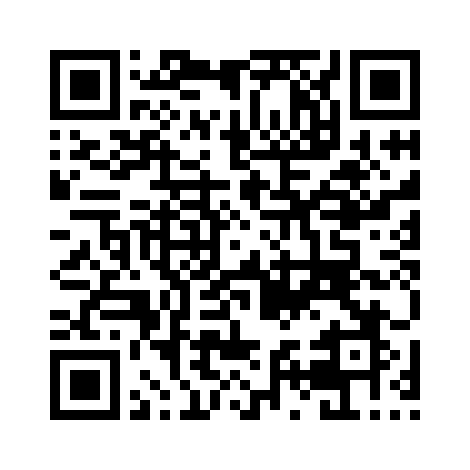

MFA setup successfully. Scan the QR code with your authenticator app.
Or use this secret key: FO54OARNLABRZB6V6P3NGHZCQS3A7P6T


In [21]:
async def setup_mfa():
    """Setup MFA for the current user"""
    if not session["token"]:
        print("Not logged in")
        return None
    
    response = await make_api_request("post", "/auth/mfa/setup", token=session["token"])
    
    if "error" in response:
        print(f"MFA setup failed: {response['error']}")
        return None
    
    # Save the secret for later use
    session["mfa_secret"] = response.get("secret")
    
    # Display QR code
    qr_code_url = response.get("qr_code")
    if qr_code_url:
        print(f"Secret key: {response['secret']}")
        display_qr_code(qr_code_url)
    
    return response

# Setup MFA
mfa_setup = await setup_mfa()

if mfa_setup and "secret" in mfa_setup:
    print(f"MFA setup successfully. Scan the QR code with your authenticator app.")
    print(f"Or use this secret key: {mfa_setup['secret']}")

In [22]:
async def verify_mfa(code=None):
    """Verify MFA code and enable MFA"""
    if not session["token"] or not session["mfa_secret"]:
        print("Not logged in or MFA not set up")
        return None
    
    # If no code provided, generate one from the stored secret
    if not code:
        code = generate_totp_code(session["mfa_secret"])
        print(f"Generated code: {code}")
    
    data = {
        "code": code,
        "secret": session["mfa_secret"]
    }
    
    response = await make_api_request("post", "/auth/mfa/verify", data, session["token"])
    
    if "error" in response:
        print(f"MFA verification failed: {response['error']}")
        return None
    
    print("MFA enabled successfully")
    return response

# Verify MFA with auto-generated code
mfa_verified = await verify_mfa()

if mfa_verified:
    print("MFA verification successful")

Generated code: 256612
Making POST request to http://localhost:8000/auth/mfa/verify
Response status: 200
MFA enabled successfully
MFA verification successful


## 7. Check User Profile After Changes

Making POST request to http://localhost:8000/payments/buy-tokens
Response status: 500
API error: Internal Server Error


In [52]:
async def subscribe_to_plan(tier="Individual"):
    """Subscribe to a plan
    
    This function initiates a subscription to a pricing tier through the API. It sends:
    1. The tier name to subscribe to (e.g., "Individual", "Team", "Enterprise")
    2. Success and cancel URLs for the checkout process
    3. The session token for authentication
    
    The API will:
    1. Find the subscription tier with recurring billing details
    2. Create a Stripe subscription checkout session
    3. Return a checkout URL
    
    The subscription will bill monthly until canceled, based on the recurring
    billing settings configured in the subscription products.
    """
    if not session["token"]:
        print("Not logged in")
        return None
    
    data = {
        "tier": tier,
        "success_url": f"{API_BASE_URL}/payments/success?session_id={{CHECKOUT_SESSION_ID}}", 
        "cancel_url": f"{API_BASE_URL}/payments"
    }
    
    # First get subscription tiers to show what's available
    tiers = await get_subscription_tiers()
    if tiers:
        print("Available subscription tiers:")
        for t in tiers:
            if t["name"] == tier:
                highlight = "➡️ "
            else:
                highlight = "   "
                
            print(f"{highlight}{t['name']}: ${t['price']}/month - {t['credits']} credits")
        
        print(f"\nInitiating subscription to {tier} tier...")
        print(f"This will set up a recurring monthly subscription")
    
    response = await make_api_request("post", "/payments/subscribe", data, session["token"])
    
    if "error" in response:
        print(f"Subscription failed: {response['error']}")
        return None
    
    print(f"\nSubscription initiated successfully!")
    print(f"Checkout URL: {response.get('url')}")
    print(f"\nInstructions:")
    print(f"1. Click the link below to complete subscription")
    print(f"2. Use Stripe test card: 4242 4242 4242 4242")
    print(f"3. Use any future date for expiry, any 3 digits for CVC, and any name")
    print(f"4. After completion, return to this notebook and run the profile check cell")
    print(f"5. Your subscription will recur monthly until canceled")
    
    # Display checkout link
    display(HTML(f'<a href="{response.get("url")}" target="_blank">Complete Subscription</a>'))
    
    return response

# Subscribe to a plan (uncomment to execute)
subscription = await subscribe_to_plan("Individual")

Making GET request to http://localhost:8000/payments/subscription-tiers
Response status: 200
Found 4 subscription tiers
Available subscription tiers:
   Free: $0.0/month - 5 credits
➡️ Individual: $9.99/month - 100 credits
   Team: $49.99/month - 500 credits
   Enterprise: $199.99/month - 2000 credits

Initiating subscription to Individual tier...
This will set up a recurring monthly subscription
Making POST request to http://localhost:8000/payments/subscribe
Response status: 200

Subscription initiated successfully!
Checkout URL: https://checkout.stripe.com/c/pay/cs_test_a1shgx9WwnLcXT4xdMyzM64OzvVNQpZ8jZp9DKiHIWqD8tQ2m3BQWWtYv4#fidkdWxOYHwnPyd1blpxYHZxWjA0VE9oQ2hCQTRBR2JyZG5yf3xoSmtMY0lrNnFjVnBnPFdkNXN1fTUyN1V2R0d8XHBATT0wdjJxRHIzf2M1QWZgUnxhUlJJcTd0MzRCVmJpU2hwa0hcT2JPNTVEdFJ1ZlUxdCcpJ2N3amhWYHdzYHcnP3F3cGApJ2lkfGpwcVF8dWAnPyd2bGtiaWBabHFgaCcpJ2BrZGdpYFVpZGZgbWppYWB3dic%2FcXdwYHgl

Instructions:
1. Click the link below to complete subscription
2. Use Stripe test card: 4242 4242 4242

In [67]:
null = None
false = False
true = True

{
  "application": null,
  "application_fee_percent": null,
  "automatic_tax": {
    "disabled_reason": null,
    "enabled": false,
    "liability": null
  },
  "billing_cycle_anchor": 1743520714,
  "billing_cycle_anchor_config": null,
  "billing_thresholds": null,
  "cancel_at": null,
  "cancel_at_period_end": false,
  "canceled_at": null,
  "cancellation_details": {
    "comment": null,
    "feedback": null,
    "reason": null
  },
  "collection_method": "charge_automatically",
  "created": 1743520714,
  "currency": "usd",
  "current_period_end": 1746112714,
  "current_period_start": 1743520714,
  "customer": "cus_S2vR9ky8LO8p8M",
  "days_until_due": null,
  "default_payment_method": "pm_1R8pb4GD1DBgwakwkqCxqAUQ",
  "default_source": null,
  "default_tax_rates": [],
  "description": null,
  "discount": null,
  "discounts": [],
  "ended_at": null,
  "id": "sub_1R96aEGD1DBgwakwiIMYUIEt",
  "invoice_settings": {
    "account_tax_ids": null,
    "issuer": {
      "type": "self"
    }
  },
  "items": {
    "data": [
      {
        "billing_thresholds": null,
        "created": 1743520715,
        "current_period_end": 1746112714,
        "current_period_start": 1743520714,
        "discounts": [],
        "id": "si_S3D0PBBzqZsFzI",
        "metadata": {},
        "object": "subscription_item",
        "plan": {
          "active": true,
          "aggregate_usage": null,
          "amount": 999,
          "amount_decimal": "999",
          "billing_scheme": "per_unit",
          "created": 1743519444,
          "currency": "usd",
          "id": "price_1R96FkGD1DBgwakwW4YCFykW",
          "interval": "month",
          "interval_count": 1,
          "livemode": false,
          "metadata": {},
          "meter": null,
          "nickname": null,
          "object": "plan",
          "product": "prod_S3Cd01RTYeuRlq",
          "tiers_mode": null,
          "transform_usage": null,
          "trial_period_days": null,
          "usage_type": "licensed"
        },
        "price": {
          "active": true,
          "billing_scheme": "per_unit",
          "created": 1743519444,
          "currency": "usd",
          "custom_unit_amount": null,
          "id": "price_1R96FkGD1DBgwakwW4YCFykW",
          "livemode": false,
          "lookup_key": null,
          "metadata": {},
          "nickname": null,
          "object": "price",
          "product": "prod_S3Cd01RTYeuRlq",
          "recurring": {
            "aggregate_usage": null,
            "interval": "month",
            "interval_count": 1,
            "meter": null,
            "trial_period_days": null,
            "usage_type": "licensed"
          },
          "tax_behavior": "unspecified",
          "tiers_mode": null,
          "transform_quantity": null,
          "type": "recurring",
          "unit_amount": 999,
          "unit_amount_decimal": "999"
        },
        "quantity": 1,
        "subscription": "sub_1R96aEGD1DBgwakwiIMYUIEt",
        "tax_rates": []
      }
    ],
    "has_more": false,
    "object": "list",
    "total_count": 1,
    "url": "/v1/subscription_items?subscription=sub_1R96aEGD1DBgwakwiIMYUIEt"
  },
  "latest_invoice": {
    "account_country": "US",
    "account_name": "Percolation Labs, LLC",
    "account_tax_ids": null,
    "amount_due": 999,
    "amount_overpaid": 0,
    "amount_paid": 999,
    "amount_remaining": 0,
    "amount_shipping": 0,
    "application": null,
    "application_fee_amount": null,
    "attempt_count": 1,
    "attempted": true,
    "auto_advance": false,
    "automatic_tax": {
      "disabled_reason": null,
      "enabled": false,
      "liability": null,
      "status": null
    },
    "automatically_finalizes_at": null,
    "billing_reason": "subscription_create",
    "charge": "ch_3R96aFGD1DBgwakw1ZMrCLD0",
    "collection_method": "charge_automatically",
    "created": 1743520714,
    "currency": "usd",
    "custom_fields": null,
    "customer": "cus_S2vR9ky8LO8p8M",
    "customer_address": null,
    "customer_email": "amartey@gmail.com",
    "customer_name": "Saoirse Amarteifio",
    "customer_phone": null,
    "customer_shipping": null,
    "customer_tax_exempt": "none",
    "customer_tax_ids": [],
    "default_payment_method": null,
    "default_source": null,
    "default_tax_rates": [],
    "description": null,
    "discount": null,
    "discounts": [],
    "due_date": null,
    "effective_at": 1743520714,
    "ending_balance": 0,
    "footer": null,
    "from_invoice": null,
    "hosted_invoice_url": "https://invoice.stripe.com/i/acct_1QJmFmGD1DBgwakw/test_YWNjdF8xUUptRm1HRDFEQmd3YWt3LF9TM0QwdGtlMDI0dHVabDlnUGVFekNqcjVDQmFnRE4xLDEzNDA2MTUxNw0200wWMJi4qH?s=ap",
    "id": "in_1R96aEGD1DBgwakwKMQEXTRH",
    "invoice_pdf": "https://pay.stripe.com/invoice/acct_1QJmFmGD1DBgwakw/test_YWNjdF8xUUptRm1HRDFEQmd3YWt3LF9TM0QwdGtlMDI0dHVabDlnUGVFekNqcjVDQmFnRE4xLDEzNDA2MTUxNw0200wWMJi4qH/pdf?s=ap",
    "issuer": {
      "type": "self"
    },
    "last_finalization_error": null,
    "latest_revision": null,
    "lines": {
      "data": [
        {
          "amount": 999,
          "amount_excluding_tax": 999,
          "currency": "usd",
          "description": "1 \u00d7 Individual Subscription (at $9.99 / month)",
          "discount_amounts": [],
          "discountable": true,
          "discounts": [],
          "id": "il_1R96aEGD1DBgwakwSQtroOCn",
          "invoice": "in_1R96aEGD1DBgwakwKMQEXTRH",
          "livemode": false,
          "metadata": {
            "tier": "Individual Subscription",
            "user_id": "10e0a97d-a064-553a-9043-3c1f0a6e6725"
          },
          "object": "line_item",
          "parent": {
            "invoice_item_details": null,
            "subscription_item_details": {
              "invoice_item": null,
              "proration": false,
              "proration_details": {
                "credited_items": null
              },
              "subscription": "sub_1R96aEGD1DBgwakwiIMYUIEt",
              "subscription_item": "si_S3D0PBBzqZsFzI"
            },
            "type": "subscription_item_details"
          },
          "period": {
            "end": 1746112714,
            "start": 1743520714
          },
          "plan": {
            "active": true,
            "aggregate_usage": null,
            "amount": 999,
            "amount_decimal": "999",
            "billing_scheme": "per_unit",
            "created": 1743519444,
            "currency": "usd",
            "id": "price_1R96FkGD1DBgwakwW4YCFykW",
            "interval": "month",
            "interval_count": 1,
            "livemode": false,
            "metadata": {},
            "meter": null,
            "nickname": null,
            "object": "plan",
            "product": "prod_S3Cd01RTYeuRlq",
            "tiers_mode": null,
            "transform_usage": null,
            "trial_period_days": null,
            "usage_type": "licensed"
          },
          "pretax_credit_amounts": [],
          "price": {
            "active": true,
            "billing_scheme": "per_unit",
            "created": 1743519444,
            "currency": "usd",
            "custom_unit_amount": null,
            "id": "price_1R96FkGD1DBgwakwW4YCFykW",
            "livemode": false,
            "lookup_key": null,
            "metadata": {},
            "nickname": null,
            "object": "price",
            "product": "prod_S3Cd01RTYeuRlq",
            "recurring": {
              "aggregate_usage": null,
              "interval": "month",
              "interval_count": 1,
              "meter": null,
              "trial_period_days": null,
              "usage_type": "licensed"
            },
            "tax_behavior": "unspecified",
            "tiers_mode": null,
            "transform_quantity": null,
            "type": "recurring",
            "unit_amount": 999,
            "unit_amount_decimal": "999"
          },
          "pricing": {
            "price_details": {
              "price": "price_1R96FkGD1DBgwakwW4YCFykW",
              "product": "prod_S3Cd01RTYeuRlq"
            },
            "type": "price_details",
            "unit_amount_decimal": "999"
          },
          "proration": false,
          "proration_details": {
            "credited_items": null
          },
          "quantity": 1,
          "subscription": "sub_1R96aEGD1DBgwakwiIMYUIEt",
          "subscription_item": "si_S3D0PBBzqZsFzI",
          "tax_amounts": [],
          "tax_rates": [],
          "taxes": [],
          "type": "subscription",
          "unit_amount_excluding_tax": "999"
        }
      ],
      "has_more": false,
      "object": "list",
      "total_count": 1,
      "url": "/v1/invoices/in_1R96aEGD1DBgwakwKMQEXTRH/lines"
    },
    "livemode": false,
    "metadata": {},
    "next_payment_attempt": null,
    "number": "2FDFD0B9-0011",
    "object": "invoice",
    "on_behalf_of": null,
    "paid": true,
    "paid_out_of_band": false,
    "parent": {
      "quote_details": null,
      "subscription_details": {
        "metadata": {
          "tier": "Individual Subscription",
          "user_id": "10e0a97d-a064-553a-9043-3c1f0a6e6725"
        },
        "subscription": "sub_1R96aEGD1DBgwakwiIMYUIEt"
      },
      "type": "subscription_details"
    },
    "payment_intent": {
      "amount": 999,
      "amount_capturable": 0,
      "amount_details": {
        "tip": {}
      },
      "amount_received": 999,
      "application": null,
      "application_fee_amount": null,
      "automatic_payment_methods": null,
      "canceled_at": null,
      "cancellation_reason": null,
      "capture_method": "automatic",
      "client_secret": "pi_3R96aFGD1DBgwakw1gsarkBZ_secret_Ep3vjAJDo9qUQ2ih5xVuVefVK",
      "confirmation_method": "automatic",
      "created": 1743520715,
      "currency": "usd",
      "customer": "cus_S2vR9ky8LO8p8M",
      "description": "Subscription creation",
      "id": "pi_3R96aFGD1DBgwakw1gsarkBZ",
      "invoice": "in_1R96aEGD1DBgwakwKMQEXTRH",
      "last_payment_error": null,
      "latest_charge": "ch_3R96aFGD1DBgwakw1ZMrCLD0",
      "livemode": false,
      "metadata": {},
      "next_action": null,
      "object": "payment_intent",
      "on_behalf_of": null,
      "payment_method": "pm_1R8pb4GD1DBgwakwkqCxqAUQ",
      "payment_method_configuration_details": null,
      "payment_method_options": {
        "amazon_pay": {
          "express_checkout_element_session_id": null
        },
        "card": {
          "installments": null,
          "mandate_options": null,
          "network": null,
          "request_three_d_secure": "automatic"
        },
        "cashapp": {},
        "link": {
          "persistent_token": null
        }
      },
      "payment_method_types": [
        "amazon_pay",
        "card",
        "cashapp",
        "link"
      ],
      "processing": null,
      "receipt_email": null,
      "review": null,
      "setup_future_usage": "off_session",
      "shipping": null,
      "source": null,
      "statement_descriptor": null,
      "statement_descriptor_suffix": null,
      "status": "succeeded",
      "transfer_data": null,
      "transfer_group": null
    },
    "payment_settings": {
      "default_mandate": null,
      "payment_method_options": null,
      "payment_method_types": null
    },
    "period_end": 1743520714,
    "period_start": 1743520714,
    "post_payment_credit_notes_amount": 0,
    "pre_payment_credit_notes_amount": 0,
    "quote": null,
    "receipt_number": null,
    "rendering": null,
    "shipping_cost": null,
    "shipping_details": null,
    "starting_balance": 0,
    "statement_descriptor": null,
    "status": "paid",
    "status_transitions": {
      "finalized_at": 1743520714,
      "marked_uncollectible_at": null,
      "paid_at": 1743520714,
      "voided_at": null
    },
    "subscription": "sub_1R96aEGD1DBgwakwiIMYUIEt",
    "subscription_details": {
      "metadata": {
        "tier": "Individual Subscription",
        "user_id": "10e0a97d-a064-553a-9043-3c1f0a6e6725"
      }
    },
    "subtotal": 999,
    "subtotal_excluding_tax": 999,
    "tax": null,
    "test_clock": null,
    "total": 999,
    "total_discount_amounts": [],
    "total_excluding_tax": 999,
    "total_pretax_credit_amounts": [],
    "total_tax_amounts": [],
    "total_taxes": [],
    "transfer_data": null,
    "webhooks_delivered_at": null
  },
  "livemode": false,
  "metadata": {
    "tier": "Individual Subscription",
    "user_id": "10e0a97d-a064-553a-9043-3c1f0a6e6725"
  },
  "next_pending_invoice_item_invoice": null,
  "object": "subscription",
  "on_behalf_of": null,
  "pause_collection": null,
  "payment_settings": {
    "payment_method_options": null,
    "payment_method_types": null,
    "save_default_payment_method": "off"
  },
  "pending_invoice_item_interval": null,
  "pending_setup_intent": null,
  "pending_update": null,
  "plan": {
    "active": true,
    "aggregate_usage": null,
    "amount": 999,
    "amount_decimal": "999",
    "billing_scheme": "per_unit",
    "created": 1743519444,
    "currency": "usd",
    "id": "price_1R96FkGD1DBgwakwW4YCFykW",
    "interval": "month",
    "interval_count": 1,
    "livemode": false,
    "metadata": {},
    "meter": null,
    "nickname": null,
    "object": "plan",
    "product": "prod_S3Cd01RTYeuRlq",
    "tiers_mode": null,
    "transform_usage": null,
    "trial_period_days": null,
    "usage_type": "licensed"
  },
  "quantity": 1,
  "schedule": null,
  "start_date": 1743520714,
  "status": "active",
  "test_clock": null,
  "transfer_data": null,
  "trial_end": null,
  "trial_settings": {
    "end_behavior": {
      "missing_payment_method": "create_invoice"
    }
  },
  "trial_start": null
}

{'application': None,
 'application_fee_percent': None,
 'automatic_tax': {'disabled_reason': None,
  'enabled': False,
  'liability': None},
 'billing_cycle_anchor': 1743520714,
 'billing_cycle_anchor_config': None,
 'billing_thresholds': None,
 'cancel_at': None,
 'cancel_at_period_end': False,
 'canceled_at': None,
 'cancellation_details': {'comment': None, 'feedback': None, 'reason': None},
 'collection_method': 'charge_automatically',
 'created': 1743520714,
 'currency': 'usd',
 'current_period_end': 1746112714,
 'current_period_start': 1743520714,
 'customer': 'cus_S2vR9ky8LO8p8M',
 'days_until_due': None,
 'default_payment_method': 'pm_1R8pb4GD1DBgwakwkqCxqAUQ',
 'default_source': None,
 'default_tax_rates': [],
 'description': None,
 'discount': None,
 'discounts': [],
 'ended_at': None,
 'id': 'sub_1R96aEGD1DBgwakwiIMYUIEt',
 'invoice_settings': {'account_tax_ids': None, 'issuer': {'type': 'self'}},
 'items': {'data': [{'billing_thresholds': None,
    'created': 1743520715,
  

## Adding a Payment Method